## Importing libs

In [27]:
import pandas as pd
import os
from tqdm import tqdm 
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

## Importing data

In [5]:
df_tweets = (
    pd.read_csv('tweets/all_tweets.csv')
    .iloc[:, 1:]
)

In [7]:
df_tweets.shape

(359036, 28)

In [16]:
users = (
    pd.read_pickle('data_users.pkl')
    .rename(columns={'username': 'author'})[['author','followers_count',
                                             'following_count', 'tweet_count']]
)

In [17]:
users.shape

(204, 4)

## Getting sentiment from tweets

- Using sentiment trained model from a mix of gathered movie and product reviews, and tweet dataset
- 

https://huggingface.co/savasy/bert-base-turkish-sentiment-cased

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
# load model, it takes time since it loads over 500 MB model file
model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

# create pipeline
sa= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

In [ ]:
df = (
    pd.read_csv('tweets/all_tweets.csv', usecols=['id', 'lang', 'text'])
    .query('lang == "tr"')
    .drop(columns=['lang'])
)

In [ ]:
for _, i in tqdm(df.iterrows()):
    sa_text = sa(i['text'])
    if sa_text[0]['label'] == 'negative':
        i['sentiment'] = -sa_text[0]['score']
    else:
        i['sentiment'] = sa_text[0]['score']
        
        
    i.to_frame().T.to_csv(f'sentiment/{i["id"]}.csv', index=False)

In [ ]:
df_sa = pd.DataFrame()

for i in tqdm(os.listdir('sentiment/')):
    df_sa = pd.concat([df_sa, pd.read_csv(f'sentiment/{i}')])

In [ ]:
# df_sa.to_csv('tweets_sentiment.csv', index=False)

In [8]:
df_sa = pd.read_csv('tweets_sentiment.csv')

In [51]:
df_sa.head(2)

,id,text,sentiment
0,1478516695279050757,Kazakistan’da neler oluyor? https://t.co/tF7Rl...,0.766581
1,1478584786549710855,RT @EsitlikVeAdalet: #2022 dayanışma yılı olac...,-0.619649


In [54]:
df_sa['positive'] = np.where(df_sa['sentiment']>0, df_sa['sentiment'], 0)
df_sa['negative'] = np.where(df_sa['sentiment']<0, -df_sa['sentiment'], 0)

In [55]:
df_sa.head(2)

,id,text,sentiment,positive,negative
0,1478516695279050757,Kazakistan’da neler oluyor? https://t.co/tF7Rl...,0.766581,0.766581,0.000000
1,1478584786549710855,RT @EsitlikVeAdalet: #2022 dayanışma yılı olac...,-0.619649,0.000000,0.619649


## Modeling

In [56]:
df = (
    pd.merge(
        df_tweets[['id', 'in_reply_to_user_id', 'quote_count', 'retweet_count', 'like_count', 'text', 'hashtags', 'reply_count', 'is_retweet', 'media_keys', 'mentions']],
        df_sa[['id', 'sentiment', 'positive', 'negative']] , on='id'
    )
    .set_index('id')
)

### EDA

Trying to visualy identify whether negative or positive sentiments results in higher likes or retweets for each tweet type

In [42]:
def plot_sentiment(data, tweet_type):
    _, ax = plt.subplots(1, 2, figsize=(18, 4))
    sns.scatterplot(
        data=data.query('tweet_type == @tweet_type'),
        x='sentiment',
        y='like_count',
        ax=ax[0]
    )

    sns.scatterplot(
        data=data.query('tweet_type == @tweet_type'),
        x='sentiment',
        y='retweet_count',
        ax=ax[1]
    );

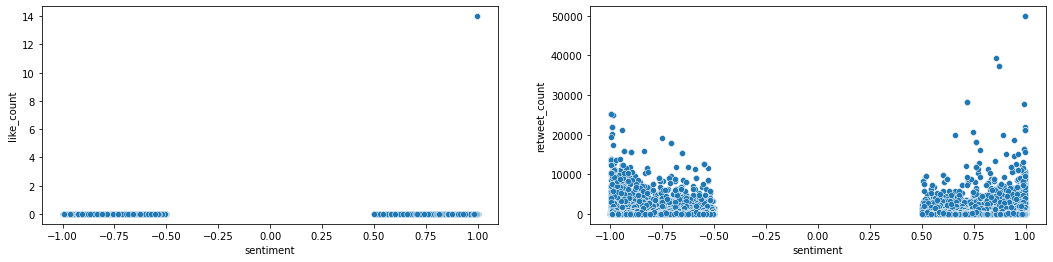

In [44]:
plot_sentiment(df, 'only_retweet')

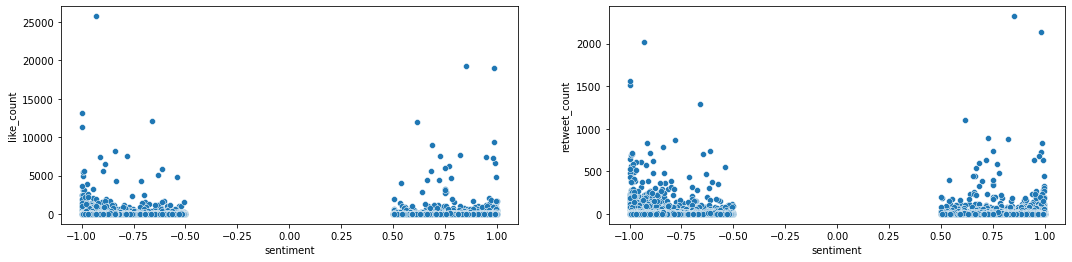

In [45]:
plot_sentiment(df, 'only_reply')

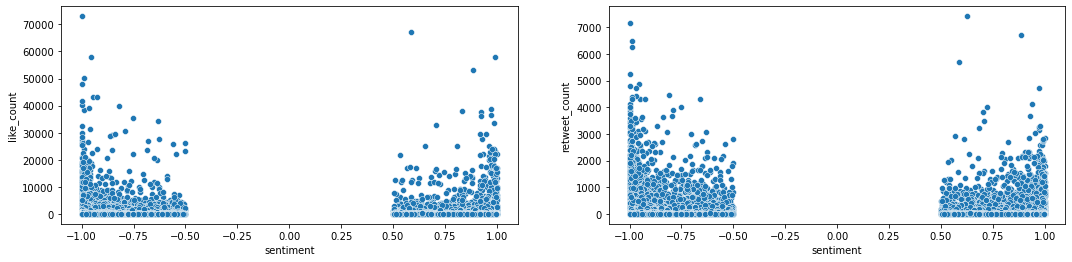

In [46]:
plot_sentiment(df, 'no_reply_and_retweet')

### Feature Engineering

In [59]:
df['text_length'] = df['text'].apply(lambda x: len(x))
df['has_media'] = np.where(df['media_keys'].isna(), 0, 1)
df['has_hashtags'] = np.where(df['hashtags'].isna(), 0, 1)
df['has_mentions'] = np.where(df['mentions'].isna(), 0, 1)
df['is_retweet'] = df['is_retweet'].astype(int)
df['is_reply'] = np.where(df['in_reply_to_user_id'].isna(), 0, 1)

- tweets that are retweets and that are reply present distinct popularity behavour when it comes to number of likes and retweets
- therefore we created different models for each of the following tweeet types:
    - is only reply tweet
    - is only retweet tweet
    - isn' reply nor retweet tweet
    - there were not tweets that are reply and retweet

In [60]:
df['tweet_type'] = np.where(df['is_reply']==1, 'only_reply',
                      np.where(df['is_retweet']==1, 'only_retweet', 'no_reply_and_retweet'))

df = df.drop(columns=['text','media_keys', 'hashtags' ,'mentions', 'in_reply_to_user_id', 'is_reply', 'is_retweet', 'sentiment'])

### Applying Logistic Regression

In [61]:
def prepare_dataset(data, target, tweet_type, features=['positive', 'negative', 'text_length','has_media', 'has_hashtags', 'has_mentions']):
    data = data.query('tweet_type == @tweet_type')
    
    x = data[features]
    y = np.where(data[target] > data[target].median(), 1, 0)
    
    return x, y

def train_test_lr(x, y, lr=LogisticRegression()):
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    
    print(classification_report(y_test, y_pred))
    
    plt.axvline(x=1, color='red')
    pd.Series(np.exp(lr.coef_[0]), index=lr.feature_names_in_).sort_values().plot.barh()
    plt.show()

=========> Modeling for tweet types:  no_reply_and_retweet
Selected target:  like_count
              precision    recall  f1-score   support

           0       0.61      0.66      0.63     14465
           1       0.63      0.58      0.60     14398

    accuracy                           0.62     28863
   macro avg       0.62      0.62      0.62     28863
weighted avg       0.62      0.62      0.62     28863



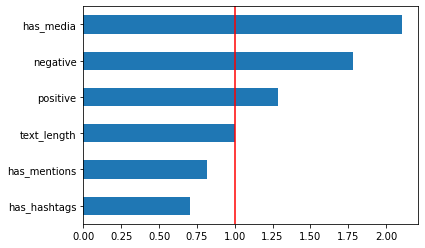


Selected target:  retweet_count
              precision    recall  f1-score   support

           0       0.60      0.67      0.64     14922
           1       0.60      0.52      0.56     13941

    accuracy                           0.60     28863
   macro avg       0.60      0.60      0.60     28863
weighted avg       0.60      0.60      0.60     28863



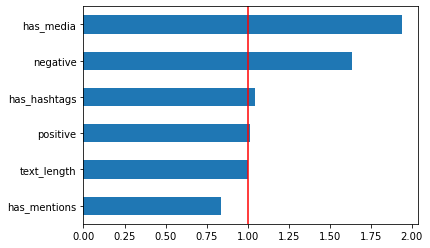


=========> Modeling for tweet types:  only_retweet
Selected target:  like_count

Selected target:  retweet_count
              precision    recall  f1-score   support

           0       0.62      0.45      0.52     21558
           1       0.56      0.71      0.62     20798

    accuracy                           0.58     42356
   macro avg       0.59      0.58      0.57     42356
weighted avg       0.59      0.58      0.57     42356



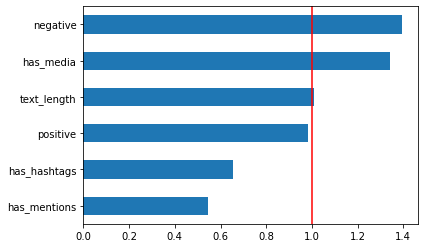


=========> Modeling for tweet types:  only_reply
Selected target:  like_count
              precision    recall  f1-score   support

           0       0.66      0.89      0.76      6260
           1       0.69      0.35      0.47      4394

    accuracy                           0.67     10654
   macro avg       0.67      0.62      0.61     10654
weighted avg       0.67      0.67      0.64     10654



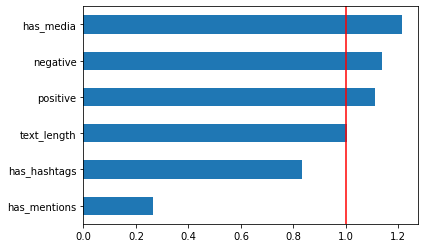


Selected target:  retweet_count
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      6248
           1       0.65      0.47      0.54      4406

    accuracy                           0.67     10654
   macro avg       0.67      0.64      0.64     10654
weighted avg       0.67      0.67      0.66     10654



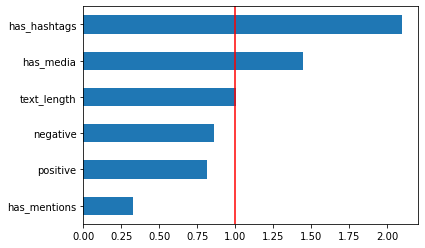

In [62]:
for i in df['tweet_type'].unique():
    print('=========> Modeling for tweet types: ', i)
    for j in ['like_count', 'retweet_count']:        
        print('Selected target: ', j)
        
        x, y = prepare_dataset(df, j, i)
        try:
            train_test_lr(x, y)
        except:
            pass
        
        print('='*60)
        print('='*60, '\n')

Some main conclusions are:
- no_reply_and_retweet
    - has_media is the feature that contributes more to likes and retweets
    - negative tweets seems to be more popular (higher likes and retweets) than postive ones
- only_retweet
    - negative sentiment is the most important feature to drive retweets